<a href="https://colab.research.google.com/github/swapneel999/Major-Project-Pneumonia-Classifier/blob/main/Pneumonia_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following python program classifies X-rays of patients and determines whether the said patient has Pneumonia or not.

The model used is Inception_v3 which yields a good testing and training accuracy. 

The model is also deployed as a webapp using streamlit.

In [1]:
#Getting the Dataset
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"swapneelm99","key":"aaca50951ba4d2f3017a4b22ed9dfdd0"}'}

In [3]:
 ! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.27G/2.29G [01:10<00:00, 34.7MB/s]
100% 2.29G/2.29G [01:10<00:00, 34.9MB/s]


In [ ]:
! mkdir dataset
! unzip chest-xray-pneumonia.zip -d dataset

In [8]:
#Preprocessing the Dataset
# Importing the necessary libraries

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [9]:
#Data Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, 
                                  width_shift_range = 0.2, height_shift_range = 0.2, 
                                 shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255.)

validation_datagen = ImageDataGenerator(rescale=1./255.)

In [10]:
training_set = train_datagen.flow_from_directory('/content/dataset/chest_xray/train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
test_set = test_datagen.flow_from_directory('/content/dataset/chest_xray/test',
                                            target_size = (150, 150),
                                            batch_size = 32,
                                            class_mode = 'binary')

val_set = validation_datagen.flow_from_directory('/content/dataset/chest_xray/val',
                                            target_size = (150, 150),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [11]:
# Using the model InceptionV3
from keras.applications.inception_v3 import InceptionV3 

In [12]:
base_model = InceptionV3(include_top=False, weights='imagenet',input_shape=(150,150,3))

87916544/87910968 [==============================] - 2s 0us/step


In [13]:
# All the layers of the model should not necessarily be trainable and hence we only change the last layer
for layers in base_model.layers:
  layers.trainable=False

In [29]:
from tensorflow.keras import models,layers
x = base_model.output
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)

In [ ]:
model.summary()

In [31]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
inc_history = model.fit(training_set, validation_data = test_set, epochs = 20)


Epoch 1/20
163/163 [==============================] - 93s 569ms/step - loss: 0.3458 - accuracy: 0.8763 - val_loss: 0.2901 - val_accuracy: 0.8782
Epoch 2/20
163/163 [==============================] - 91s 560ms/step - loss: 0.2194 - accuracy: 0.9139 - val_loss: 0.4077 - val_accuracy: 0.8446
Epoch 3/20
163/163 [==============================] - 92s 562ms/step - loss: 0.1948 - accuracy: 0.9224 - val_loss: 0.4416 - val_accuracy: 0.8494
Epoch 4/20
163/163 [==============================] - 91s 560ms/step - loss: 0.1919 - accuracy: 0.9220 - val_loss: 0.3019 - val_accuracy: 0.8750
Epoch 5/20
163/163 [==============================] - 91s 561ms/step - loss: 0.1796 - accuracy: 0.9298 - val_loss: 0.3851 - val_accuracy: 0.8574
Epoch 6/20
163/163 [==============================] - 91s 561ms/step - loss: 0.1841 - accuracy: 0.9275 - val_loss: 0.3558 - val_accuracy: 0.8686
Epoch 7/20
163/163 [==============================] - 93s 569ms/step - loss: 0.1721 - accuracy: 0.9352 - val_loss: 0.4391 - val_ac

In [34]:
result  = model.evaluate(test_set, steps=len(test_set), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

20/20 [==============================] - 6s 307ms/step - loss: 0.2843 - accuracy: 0.8942
Loss: 0.28433915972709656
Accuracy: 0.8942307829856873


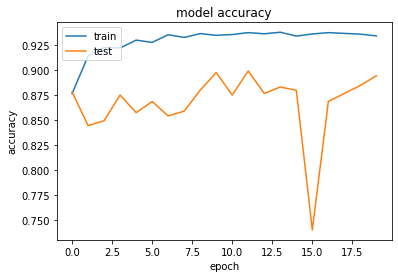

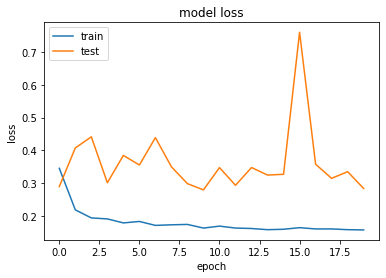

In [35]:
plt.plot(inc_history.history['accuracy'])
plt.plot(inc_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(inc_history.history['loss'])
plt.plot(inc_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

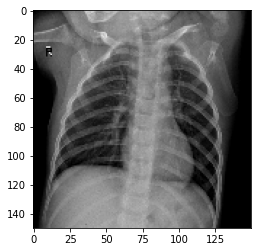

In [36]:
from keras.preprocessing import image
x = image.load_img('/content/dataset/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg',target_size=(150,150))
plt.imshow(x)

In [37]:
import numpy as np
from keras.applications.inception_v3 import preprocess_input,decode_predictions 

x_resize = image.img_to_array(x)
print(x_resize.shape)
x_resize = np.expand_dims(x_resize,axis =0)
print(x_resize.shape)
x_final = preprocess_input(x_resize)

(150, 150, 3)
(1, 150, 150, 3)


In [38]:
predictions = model.predict(x_final)
print(predictions)
predictions = predictions.reshape(1,-1)[0]
predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0
predictions

[[0.02971809]]


array([0.], dtype=float32)

In [39]:
if predictions==0:
  print('The chest x-ray is normal')
else:
  print('The chest x-ray shows Pneumonia')

The chest x-ray is normal


In [40]:
model.save('pneumonia.h5')

In [ ]:
!pip install streamlit

!pip install pyngrok
import pyngrok

In [42]:
%%writefile app.py
import numpy as np
import streamlit as st
from skimage.io import imread
from skimage.transform import resize
from PIL import Image
import tensorflow as tf
from keras.applications.inception_v3 import preprocess_input,decode_predictions
from keras.preprocessing import image
import os


st.set_option('deprecation.showfileUploaderEncoding',False)
st.title("Pneumonia Detector")
st.text("Upload your image")

model = tf.keras.models.load_model('pneumonia.h5')
uploaded_file = st.file_uploader("Choose the image...", type = 'jpg')



if uploaded_file is not None:


  img = Image.open(uploaded_file)
  img = img.resize((300,250))
  st.image(img, caption = "Uploaded Image")

  st.write("")

  if st.button('Predict'):
    st.write('Result..')
    img = image.img_to_array(img)
    img = resize(img,(150,150,3), anti_aliasing = True, mode = 'reflect')
    img = np.expand_dims(img,axis =0)
    img = preprocess_input(img)
    predictions = model.predict(img)
    predictions = predictions.reshape(1,-1)[0]
    predictions[predictions >= 0.5] = 1
    predictions[predictions < 0.5] = 0
    if predictions==0:
      y_out= 'The chest x-ray is normal'
    else:
      y_out='The chest x-ray shows Pneumonia'
    st.title(f"Predicted output:{y_out}")

Overwriting app.py


In [43]:
from pyngrok import ngrok
!nohup streamlit run app.py &

public_url = ngrok.connect(port = '8501')
print(public_url)

nohup: appending output to 'nohup.out'
http://42cf319fd99d.ngrok.io


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Support for "return_ngrok_tunnel" as "False" is deprecated and will be removed in 5.0.0, when this method will return a NgrokTunnel instead of a str
  after removing the cwd from sys.path.
